In [18]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

The standard form formula for optimization is ===>
    min(1/2)x(T) * (p)(x) + q(T) * x     Subject to   Gx <= h , Ax= b

 We need to convert SVM to QP form. The standard form formola of the dual problem with qp is===>

min (1/2)a(T) * H(a) - a             Subject to  −a(i)≤0 , a(i)<=C ,  y(T)a=0   

In [21]:
class SVM(object):

    def __init__(self,kernel=linear_kernel, C=None): # c is error coefficient
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        print("input shape is : " , X.shape) 

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j]) # Matrix K is 200 * 200

        P = cvxopt.matrix(np.outer(y,y) * K) # P is a positive-definite matrix ( matrix in qp func to be minimizes)
        q = cvxopt.matrix(np.ones(n_samples) * -1) # The vector q has all entries −1( vectors in qp func to be minimizes)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0) # vectors holding values of b defult =0

        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        G

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        

        # find Lagrange multipliers
        landa = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = landa > 1e-5
        index = np.arange(len(landa))[sv]
        self.landa = landa[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        print("Landas are :" , self.landa) # print landas
        print("support vector coordinates are : " , self.sv)  #point coordinates that have non zero lagrange multipliers
        print("support vector labels are :" , self.sv_y) #labels for support vectors

        # bias
        self.b = 0
        for n in range(len(self.landa)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.landa * self.sv_y * K[index[n],sv])
        self.b /= len(self.landa)
        print("bais is: " , self.b) 


        # Weight vector
        self.w = np.zeros(n_features)
        for n in range(len(self.landa)):
            self.w += self.landa[n] * self.sv_y[n] * self.sv[n]
        print("weights are: " , self.w)  
        

    def project(self, X):
            return np.dot(X, self.w) + self.b
        

    def predict(self, X):
        return np.sign(self.project(X))

input shape is :  (200, 2)
     pcost       dcost       gap    pres   dres
 0: -6.5059e+02 -1.4534e+06  4e+06  9e-01  8e-13
 1:  3.3824e+03 -4.0335e+05  6e+05  7e-02  6e-13
 2:  1.8691e+03 -6.0461e+04  7e+04  6e-03  5e-13
 3: -1.1248e+03 -9.7938e+03  9e+03  5e-04  4e-13
 4: -1.4386e+03 -3.9533e+03  3e+03  1e-04  4e-13
 5: -1.5436e+03 -3.8163e+03  2e+03  8e-05  4e-13
 6: -1.5967e+03 -3.0538e+03  1e+03  4e-05  4e-13
 7: -1.6841e+03 -2.3986e+03  7e+02  2e-05  4e-13
 8: -1.7520e+03 -2.4053e+03  7e+02  1e-05  4e-13
 9: -1.7694e+03 -2.2625e+03  5e+02  4e-07  5e-13
10: -1.7877e+03 -2.2000e+03  4e+02  3e-07  4e-13
11: -1.8001e+03 -2.1940e+03  4e+02  2e-07  4e-13
12: -1.8181e+03 -2.1396e+03  3e+02  7e-08  4e-13
13: -1.9058e+03 -2.0222e+03  1e+02  2e-13  6e-13
14: -1.9427e+03 -1.9692e+03  3e+01  4e-13  5e-13
15: -1.9533e+03 -1.9539e+03  6e-01  4e-13  5e-13
16: -1.9536e+03 -1.9536e+03  6e-03  1e-13  5e-13
17: -1.9536e+03 -1.9536e+03  6e-05  1e-13  4e-13
Optimal solution found.
Landas are : [99.99

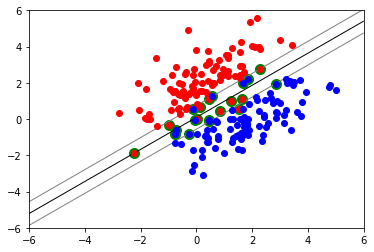

In [20]:
if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def join_X_y(X1, y1, X2, y2):
        sampels = np.vstack((X1, X2))
        labels = np.hstack((y1, y2)) 
        return sampels, labels 
       

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        # plot decision boundray
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()


    def soft_margin():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        sampels, labels = join_X_y(X1, y1, X2, y2)

        clf = SVM(C=100.)
        clf.fit(sampels, labels)

        plot_contour(sampels[labels==1], sampels[labels==-1], clf)

        
    soft_margin()